<a href="https://colab.research.google.com/github/dandoreyrodriguez/Bayesian_Econometrics/blob/main/BE_Koop_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Class 1 in Bayesian Econometrics**

## **Motivation**

This is the first in a series of notebooks which document my journey learning Bayesian econometrics. It is intended for people who, like me, have zero background in Bayesian statistics but have a background in statistics/econometrics. The point of this is not to mimic a textbook, but to show how I slowly begin to understand things. My hope is that I can closely track the difficulties other new students encounter, and that the reader can learn from them. The reason I figured I had to learn Bayesian statistics is that Bayesian techniques offer versatility within a relatively simple framework. Compare this to a Kalman Filter, which requires normality and hence is not very general as a statistical approach. A large goal of this series is to help new students learn to use Bayesian tools in python, chiefly `pyMC`, since computation is crucial to Bayesian statistics.

I learn by doing. In this intro class, I consider two models: a very basic binomial model and a normal linear regression model. Using these examples, I demonstrate what doing Bayesian statistics looks like and show the main objects of interest in Bayesian econometrics. In each case, I give an example where an analytical solution can be found by hand. I also show why computational methods are so important.

I do not shy away from doing statistical theory as I am a firm believer that practitioners should not use techniques whose theoretical properties they do not understand. If the reader struggles with this, I hope they may find comfort in knowing that I did too.

The single most useful resource I found online was this pyData [talk](https://www.youtube.com/watch?v=911d4A1U0BE&t=773s). The binomial example is taken directly from this talk.

Future notebooks will go over other applications. My goal in this series is to reach state space time series models and perhaps general equilibrium macro models---if I am lucky.

Happy learning.


## **A Binomial Model**

Imagine you were interested in estimating the probability, $\theta \in [0,1]$, that a baseball batter strikes out from data corresponding to $n$ plate appearances. Suppose that in $n$ appearances, or trials, the batter strikes out $y \in \{0, 1, \cdots, n\}$ times. If these trials are independent, then $P(y|\theta) = \frac{n!}{y! (n-y)! } \theta^y (1-\theta)^{n-y}$ is the probability mass function corresponding to $y$. That is, the number of times the batter strikes out follows the familiar binomial distribution.

A Bayesian wants to learn about the *posterior* distribution which characterises uncertainty regarding the parameter after having seen the data. In this example, everything is one dimensional, and hence simple. In this case, the posterior, $f(\theta|y)$, will be a probability density function.

Using Bayes rule,

$$f(\theta | y) = \frac{f(y|\theta)f(\theta)}{f(y)}$$

Let's inspect these objects one by one:
- $f(y|\theta)$ is simply the likelihood function. In the discrete case, the likelihood function *is* the probability mass function, $P(y|\theta)$. The likelihood function is familiar to us from when we do frequentist statistics!
- $f(\theta)$ is the prior distribution. It characterises the statistician's uncertainty about the true strikeout rate before seeing the data. In our case, this will be a continuous probability density function.
- $f(y)$ is the marginal evidence. It is the probability of observing the data given our uncertainty about the parameter prior to seeing the data. It is called the marginal to emphasises that you integrate/sum out $\theta$ using the prior. More formally, $f(y) = \int_0^1f(y|\theta) f(\theta)d\theta$.

To obtain the posterior, we need to specify the prior, $f(\theta)$. For now, I will make it a Beta distribution because it is defined on the unit line. The Beta distribution $\text{Beta}(\alpha, \beta)$ has a PDF:

$$f(\theta) = \frac{1}{\text{B}(\alpha, \beta)}\theta^{\alpha-1}(1-\theta)^{1-\beta}, \forall \theta \in [0,1], \, \forall \alpha, \beta>0$$

The beta function is defined, $\text{B}(\alpha, \beta) := \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha+\beta)}$. In turn, the Gamma function is defined: $\Gamma(z) := \int_{0}^\infty t^{z-1} e^{-t}dt$. The important point is that the Gamma function is just a definite integral, and so it it is constant! This means that the Beta function is just some constant.

Here is what a Beta distribution looks like for different parameter values. Note that it nests the uniform distribution.

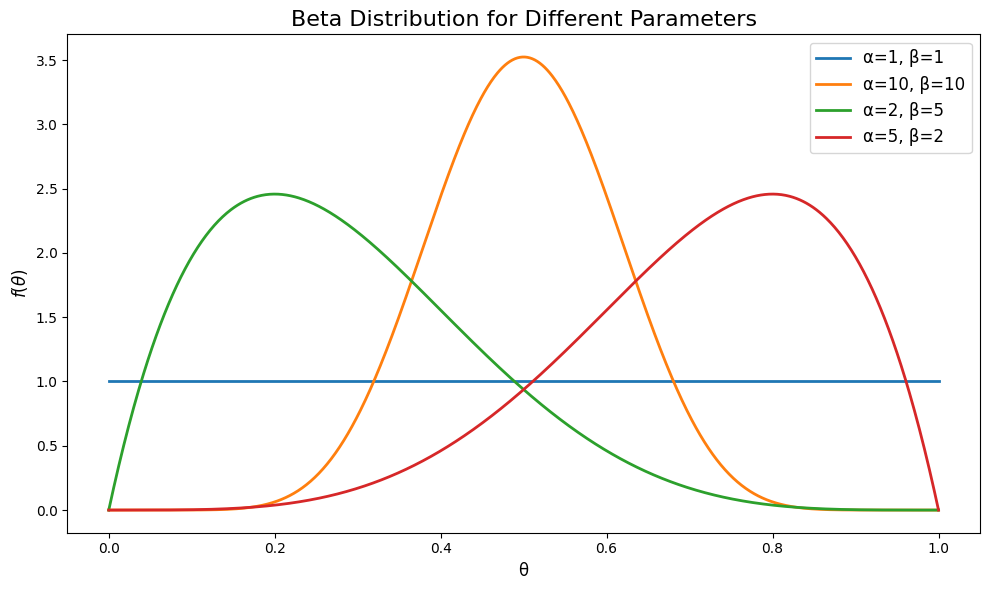

In [28]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, gamma, t


# Create an array of x values from 0 to 1
x = np.linspace(0, 1, 1000)

# Define a list of (alpha, beta) parameter pairs for the Beta distributions
params = [
    (1, 1),
    (10, 10),
    (2, 5),
    (5, 2)
]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each Beta distribution
for a, b in params:
    pdf = beta.pdf(x, a, b)
    plt.plot(x, pdf, lw=2, label=f'α={a}, β={b}')

# Add labels, title, and legend to the plot
plt.xlabel('θ', fontsize=12)
plt.ylabel(r'$f(\theta)$', fontsize=12)
plt.title('Beta Distribution for Different Parameters', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


Next, an important thing to note is that the posterior $f(\theta|y)$ fixes the value of the data. So as you vary $\theta$, $y$ remains constant. Hence, the marginal evidence, $f(y)$, is simply a scaling constant which ensures that $f(\theta|y)$ integrates to one and is a valid PDF.

Plugging everything we have in:

$$ f(\theta|y) = \frac{\frac{n!}{y! (n-y)! } \theta^y (1-\theta)^{n-y} \cdot \theta^{\alpha-1}(1-\theta)^{\beta-1} }{\text{B}(\alpha, \beta) f(y)}$$

Ignoring all the terms which contribute to the scaling constant, and considering only terms involving $\theta$:

$$f(\theta|y) \propto \theta^{y+\alpha-1}(1-\theta)^{n-y+\beta-1}$$

But hang on...this looks like a Beta distribution again! In fact, it looks like $\theta|y \sim \text{Beta}( y+\alpha, n-y+\beta)$.

How extraordinary. Given our choice of prior, once we knew how many times the batter struck out in their $n$ plat appearances, $y$, we learned the posterior! This example has two great properties:

1.  The prior distribution is a Beta distribution and the posterior distribution is a Beta distribution. This property is called *conjugacy*. This is when your choice of prior ensures that the posterior distribution belongs to the same family as the prior.
2. We didn't have to worry about the pesky constant term because we spotted that the posterior was a $\text{Beta}( y+\alpha, n-y+\beta)$. With this information, we know what the constant term is from the PDF. It's like we get it for free. This is a relief because the Beta function, factorials, and marginal evidence term were starting to give me shivers...

From this [talk](https://www.youtube.com/watch?v=911d4A1U0BE&t=773s), let's say our prior is a $\text{Beta}(10,35)$. Let's say that the baseball player of interest has 22 plate appearances, $n=22$, and strikes out just once, $y=1$. This makes the posterior a $\text{Beta}(11,56)$. Another distribution we would want to plot is what $f(\theta|y)$ would be if it were only informed by the data---and not the prior at all. In this case, $f(\theta)$ would be a constant and the posterior would be described entirely by the likelihood function.

Viusualising this, a couple of things stand out.

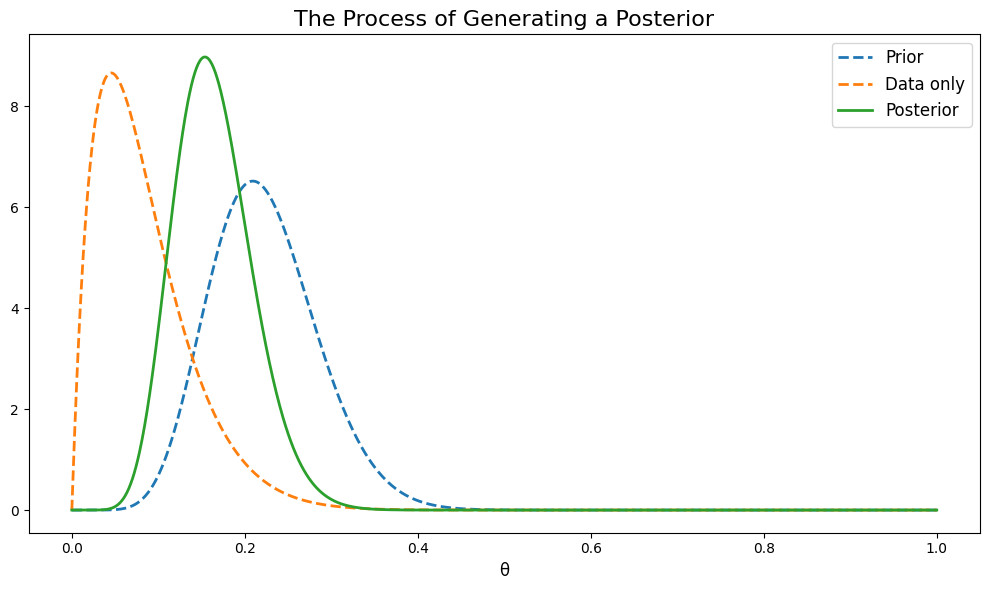

In [3]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the example prior
pdf_prior = beta.pdf(x, 10, 35)
plt.plot(x, pdf_prior, lw=2, label='Prior',linestyle = '--')

# Plot the likelihood
pdf_likelihood = beta.pdf(x, 2, 22)
plt.plot(x, pdf_likelihood, lw=2, label='Data only',linestyle = '--')

# Plot the example posterior
pdf_posterior = beta.pdf(x, 11, 56)
plt.plot(x, pdf_posterior, lw=2, label='Posterior')

# Add labels, title, and legend to the plot
plt.xlabel('θ', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title('The Process of Generating a Posterior', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


The posterior is a blend of our prior and what the posterior would have been if we were only guided by the data (if the prior placed even probability on all values).

Once we have the posterior, $f(\theta | y)$ we can pull out our usual tricks. We can:
- Estimate the parameter, say by taking the expected value $\mathbb{E}[\theta|y]$.
- Characterise the uncertainty around the parameter estimate. For example, by reporting $\text{Var}(\theta | y)$.
- Do out-of-sample estimates, where $f(y_{\text{new}}|y)= \int_0^1f(y_{\text{new}}|\theta)f(\theta | y) d \theta$. We can report uncertainty around this too!

So, I hear you ask, what is all this nonesense about computation and Monte Carlo if all Bayesian statistics is is using Bayes rule, which we learn as teenagers?

Let me illustrate to you why you need computation, *even* in this very simple example.

Suppose that our prior is not a Beta but is something else. Let's say we had the following prior:

$$f(\theta) = \frac{\pi}{2}\sin(\pi \theta ), \forall \theta \in [0,1]$$

Let's plot this and check it is a valid prior.

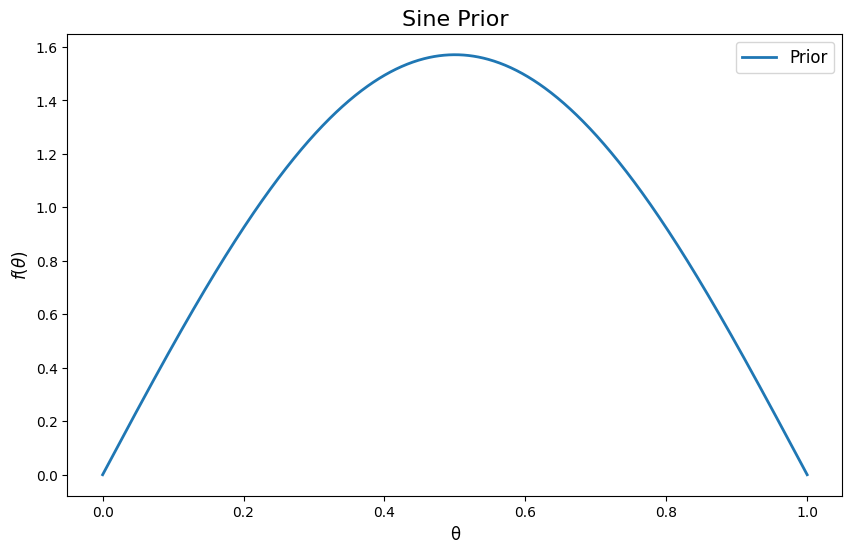

In [4]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create the density function
pdf_sin_prior = 0.5 * np.pi * np.sin(np.pi * x)

# Plot the density function
plt.plot(x, pdf_sin_prior, lw=2, label='Prior')
# Plot x label
plt.xlabel('θ', fontsize=12)
# Plot y label
plt.ylabel(r'$f(\theta)$', fontsize=12)
# Plot title
plt.title('Sine Prior', fontsize=16)
# Plot legend
plt.legend(fontsize=12)

Remembering how to integrate,

$$ \int_{0}^1 \frac{\pi}{2}\sin(\pi \theta ) d \theta = \frac{\pi}{2}\bigg[ -\frac{1}{\pi}\cos(\pi \theta) \bigg]^1_0 = \frac{\pi}{2}(\frac{1}{\pi}+\frac{1}{\pi}) = 1$$

This is exactly what we wanted. This is a valid PDF: it is non-negative on the domanin and integrates to one.

Just as last time, try to plug in Bayes rule:

$$ f(\theta|y) = \frac{\frac{n!}{y! (n-y)! } \theta^y (1-\theta)^{n-y} \cdot \frac{\pi}{2}\sin(\pi \theta )}{\text{B}(\alpha, \beta) f(y)} $$

Isolating everything involving $\theta$ and ignoring what is a constant:

$$f(\theta|y) \propto \theta^y (1-\theta)^{n-y} \cdot \sin(\pi \theta )$$

Clearly, this posterior is not quickly identifiable as some familiar distribution. This means that calculating the constant which will make this a valid PDF involves one of two options:

1. Solve for the constant, $c$, by solving the integral $\int_0^1 \theta^y (1-\theta)^{n-y} \cdot \sin(\pi \theta ) d \theta  $, which means the PDF integrates to one. This can be done analytically or by numerical approximation.
2. Use some other procedure which will let you find the posterior.

In this case, the integral is challenging but doable. However, as you leave the one dimensional and go towards the multidimensional, techniques for solving these integrals do not scale well. This is why other clever computational techniques are used: and why we will learn `pyMC`. This issue is at the heart of Bayesian statistics and is what allows us to go beyond just a few special cases where expressions are neat.

## **Linear Regression**

The baseball binomial illustrates *all* that you need to know about Bayesian objects of interest. Inded, from now on our approach will always stay similar. First, we specify our prior. Second, we combine our prior with the likelihood function and use Bayes' rule to obtain the kernel of the posterior distribution. Lastly, by computation/by hand we obtain the full posterior---with the proper scaling constant. This is the beauty of Bayes, it is *usefully general*. Nevertheless, when doing Bayes by hand for different parameter objects it is useful to do some "chaining".

The example I use is a multivariate linear regression model---probably the most widely used model. To motivate the example I will use a classic dataset capturing TV, radio, and newspaper advertisement spending and sales.

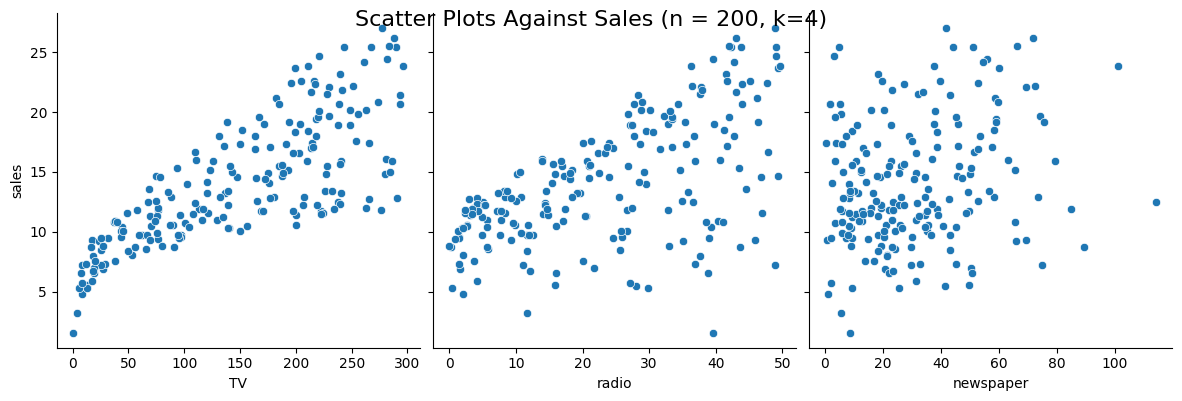

In [5]:
# Load the Advertising dataset from a URL
url = 'https://raw.githubusercontent.com/selva86/datasets/master/Advertising.csv'
df = pd.read_csv(url, index_col=0)

# Plot pairwise scatter plots against sales
sns.pairplot(df, x_vars=['TV', 'radio', 'newspaper'], y_vars='sales', height=4, aspect=1, kind='scatter')
# Plot title
plt.suptitle(f'Scatter Plots Against Sales (n = {len(df)}, k=4)', fontsize=16)
# Display the plot
plt.show()




Suppose that $\boldsymbol{y}$ is a $n \times 1 $ vector of data and $\boldsymbol{X}$ is a $n \times k$ design matrix. The $i$th row of this matrix is $\boldsymbol{x}_i'$, where $\boldsymbol{x}_i$ is a $k\times1$ vector which stores each of the features, or independent variables, for the $i$th observation. One of these features is usually 1, representing an intercept term. $\boldsymbol{\epsilon}$ is a $n\times1$ vector of error terms. A normal linear regression model can be written as:

$$\boldsymbol{y}= \boldsymbol{X}\boldsymbol{\beta}+\boldsymbol{\epsilon}, \, \boldsymbol{\epsilon} \overset{\text{i.i.d}}{\sim} \text{N}(\boldsymbol{0}, h^{-1} \boldsymbol{I})$$

Normality ensures homoskedasticity and serially-uncorrelatedness of errors.  $h = \sigma^{-2}$ is a measure of "tightness" of errors. $\boldsymbol{\beta}$ is a $k \times 1$ vector of parameters of interest. So, in this context, how would a Bayesian learn about $\boldsymbol{\theta} = [ \boldsymbol{\beta}, h]'$?

First, we specify our priors:

- $\boldsymbol{\beta}|h \sim \text{N}(\boldsymbol{\beta}_0, h^{-1}\boldsymbol{V}_0)$
- $h \sim \text{Gamma}(a_0, b_0)$

I assume the reader is familiar with the multivariate normal PDF. Our prior for $h$, a Gamma PDF, is of the form:

$$f(h) = \frac{b_0^{a_0}}{\Gamma{a_0}}h^{a_0-1}\exp(-b_0h), \forall a_0, b_0>0$$

In the advertising example I use $a_0 = 2, \, b_0 = 50$ for the gamma prior. Moreover I set $\boldsymbol{\beta}_0 = (1, 0.05, 0.05, 0.05)'$ and $V_0 = 2 h^{-1} \boldsymbol{I}_n$. These are quite conservative quantities, which seems plausible. Below I plot the Gamma prior.  

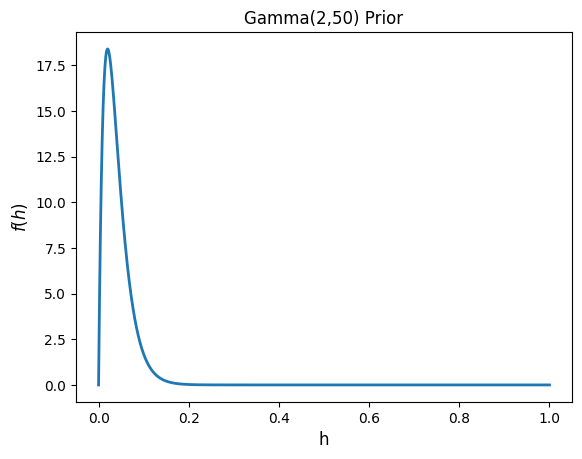

In [14]:
# Pick a Gamma prior
a_0 = 2
b_0 = 50
# Plot the Gamma PDF
x = np.linspace(0, 1, 1000)
plt.plot(x, gamma.pdf(x, a_0, scale = 1/b_0), lw=2, label='Prior')
plt.title(f'Gamma({a_0},{b_0}) Prior')
plt.xlabel('h', fontsize=12)
plt.ylabel(r'$f(h)$', fontsize=12)
plt.show()


Second, we combine our priors with the likelihood function $f(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{\beta},h )$. The likelihood function is:  


$$f(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{\beta},h) = (2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}}  \text{exp}\bigg( -\frac{h}{2}(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})' (\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})\bigg)$$

From here on you will see how we will have to do some "chaining". Let's start by considering the posterior of the regression coefficients, $\boldsymbol{\beta}$, given $h$ (treating $h$ as if it were known). We assume that $f(\boldsymbol{\beta}|\boldsymbol{X},h)=f(\boldsymbol{\beta}|h)$ by independence. Focusing on the relevant part of the posterior where $f(\boldsymbol{\beta}|\boldsymbol{y}, \boldsymbol{X},h) \propto f(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{\beta},h)  f(\boldsymbol{\beta}|h)$:


$$f(\boldsymbol{\beta}|\boldsymbol{y},\boldsymbol{X},h) \propto   \exp\bigg( -\frac{h}{2}(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})' (\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})\bigg)\exp{\bigg(-\frac{h}{2} (\boldsymbol{\beta}-\boldsymbol{\beta}_0)' \boldsymbol{V}_0^{-1} (\boldsymbol{\beta}-\boldsymbol{\beta}_0) \bigg)}$$


Expand the terms and group, just like we did when we were kids, dropping anything that does not include $\boldsymbol{\beta}$:

$$-\frac{1}{2}\boldsymbol{y}'\boldsymbol{y}+\frac{1}{2}\boldsymbol{y}'\boldsymbol{X}\boldsymbol{\beta}+\frac{1}{2}\boldsymbol{\beta}'\boldsymbol{X}'\boldsymbol{y}-\frac{1}{2}\boldsymbol{\beta}'\boldsymbol{X}'\boldsymbol{X}\boldsymbol{\beta}-\frac{1}{2}\boldsymbol{\beta}'\boldsymbol{V}_0^{-1}\boldsymbol{\beta}+\frac{1}{2}\boldsymbol{\beta}'\boldsymbol{V}_0^{-1}\boldsymbol{\beta}_0+\frac{1}{2}\boldsymbol{\beta}_0'\boldsymbol{V}_0^{-1}\boldsymbol{\beta}-\frac{1}{2}\boldsymbol{\beta}_0'\boldsymbol{V}_0^{-1}\boldsymbol{\beta}_0 \\ = \frac{1}{2}\boldsymbol{\beta}'(\boldsymbol{X}'\boldsymbol{y}+\boldsymbol{V}_0^{-1}\boldsymbol{\beta}_0)-\frac{1}{2}\boldsymbol{\beta}'(\boldsymbol{X}'\boldsymbol{X}+\boldsymbol{V}_0^{-1})\boldsymbol{\beta}+\frac{1}{2}(\boldsymbol{y}'\boldsymbol{X}+\boldsymbol{\beta}_0'\boldsymbol{V}_0^{-1})\boldsymbol{\beta}$$

Using the fact that if $\boldsymbol{a}'\boldsymbol{b}=s$ gives a scalar $s$, then the transpose of a scalar is itself ($s'=s$), you can actually rewrite the kernel as:

$$f(\boldsymbol{\beta}|\boldsymbol{y},\boldsymbol{X},h) \propto \exp\bigg(-\frac{h}{2}\boldsymbol{\beta}'(\boldsymbol{X}'\boldsymbol{X}+\boldsymbol{V}_0^{-1})\boldsymbol{\beta}+\boldsymbol{\beta}'h(\boldsymbol{X}'\boldsymbol{y}+\boldsymbol{V}_0^{-1}\boldsymbol{\beta}_0)\bigg)$$

This is a familar problem, we have a quadratic term which we want to write as a factorised quadratic. Introducing an extra constant, $\boldsymbol{c}$, does not matter because it can be offset by something in the scaling constant. In other words we want:

$$-\frac{1}{2}\boldsymbol{\beta}'(\boldsymbol{X}'\boldsymbol{X}+\boldsymbol{V}_0^{-1})\boldsymbol{\beta}+\boldsymbol{\beta}'(\boldsymbol{X}'\boldsymbol{y}+\boldsymbol{V}_0^{-1}\boldsymbol{\beta}_0) - \boldsymbol{c} = -\frac{1}{2}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)'\boldsymbol{V}_n^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)$$

It is immediately clear that $\boldsymbol{V}_n = (\boldsymbol{X}'\boldsymbol{X}+\boldsymbol{V}_0^{-1})^{-1}$ in order for the quadratic term to be right. Remember that we can ignore constant terms, we can expand the right hand side as we did before and realise that we require $\boldsymbol{V}_n^{-1}\boldsymbol{\beta}_n =  \boldsymbol{X}'\boldsymbol{y} + \boldsymbol{V}_0^{-1}\boldsymbol{\beta}_0$. Therefore:

$$\boldsymbol{\beta}|\boldsymbol{y},\boldsymbol{X},h \sim \text{N}(\boldsymbol{\beta}_n, h^{-1}\boldsymbol{V}_n)$$

- $\boldsymbol{V}_n = (\boldsymbol{X}'\boldsymbol{X}+\boldsymbol{V}_0^{-1})^{-1}$
- $\boldsymbol{\beta}_n = \boldsymbol{V}_n(\boldsymbol{V}_0^{-1}\boldsymbol{\beta}_0 +\boldsymbol{X}'\boldsymbol{y})$

I show how these updated estimates of $\boldsymbol{\beta}_n$ compare to $\boldsymbol{\beta}_0$.

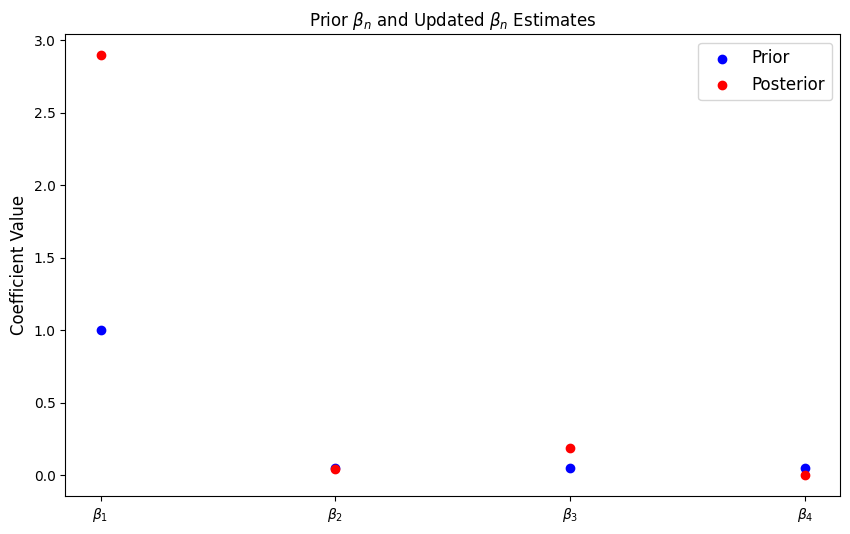

In [39]:
# get y, X, k, \beta_0, V_0
y = df['sales'].values
X = df[['TV', 'radio', 'newspaper']].values
X = np.hstack((np.ones((len(y),1)),X))
k = X.shape[1]
beta_0 = np.array([1, 0.05, 0.05, 0.05])
V_0 = 1.5 * np.eye(k)

# compute V_n
V_n = np.linalg.inv(X.T @ X + np.linalg.inv(V_0))

# compute beta_n
beta_n = V_n @ (np.linalg.inv(V_0)@beta_0 + X.T @ y)

# x positions corresponding to each beta (e.g., indices 0, 1, 2, 3)
x_positions = list(range(k))

# Define custom x-axis labels for the beta coefficients
beta_labels = [f"$\\beta_{{{i+1}}}$" for i in range(k)]

# plot beta_0 compared to beta_n
plt.figure(figsize=(10, 6))
plt.scatter(x_positions, beta_0, color='blue', label='Prior')
plt.scatter(x_positions, beta_n, color='red', label='Posterior')
plt.xticks(x_positions, beta_labels)
plt.ylabel('Coefficient Value', fontsize = 12)
plt.title(r'Prior $\boldsymbol{\beta_n}$ and Updated $\boldsymbol{\beta_n}$ Estimates')
plt.legend(fontsize = 12)
plt.show()


This is quite an important discovery! If the error tightness, $h$, is known, the posterior distribution of the vector of regression coefficients is a multivariate normal distribution also. More strikingly, suppose that you are very uncertain about the prior such that $\boldsymbol{V}_0^{-1} \to 0$. Then, $\boldsymbol{V}_n^{-1} \to (\boldsymbol{X}'\boldsymbol{X})^{-1}$ such that $\boldsymbol{\beta}_n \to (\boldsymbol{X}'\boldsymbol{X})^{-1}\boldsymbol{X}'\boldsymbol{y}$. This is exactly the Ordinary Least Squares (OLS) estimate!

Remember we are chasing the posterior, which is:

$$f(\boldsymbol{\theta}|\boldsymbol{y},\boldsymbol{X}) = \begin{bmatrix} f(\boldsymbol{\beta}|\boldsymbol{y},\boldsymbol{X}) \\\ f(h|\boldsymbol{y},\boldsymbol{X}) \end{bmatrix}$$

We have neither yet...but we are getting close! In fact we are very close...To get the posterior of the error tightness we need to use Bayes' rule:

$$f(h|\boldsymbol{y},\boldsymbol{X}) \propto f(\boldsymbol{y}|h,\boldsymbol{X})f(h)$$

$f(\boldsymbol{y}|h,\boldsymbol{X})$ is almost the likelihood function. Almost but not quite. To get it we need to do some integration.

$$f(\boldsymbol{y}|h,\boldsymbol{X})  = \int f(\boldsymbol{y}, \boldsymbol{\beta}|h,\boldsymbol{X}) d \boldsymbol{\beta} = \int f(\boldsymbol{y}| \boldsymbol{\beta},h,\boldsymbol{X}) f(\boldsymbol{\beta}|h) d \boldsymbol{\beta} $$

We have everything we need to do this integral; the likelihood function, the regression coefficients' prior, and a heavy dose of bravery!

$$f(\boldsymbol{y}|h,\boldsymbol{X})  = \int \underbrace{(2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}}  \text{exp}\bigg( -\frac{h}{2}(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})' (\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})\bigg)}_{f(\boldsymbol{y}| \boldsymbol{\beta},h,\boldsymbol{X})} \underbrace{(2 \pi)^{-\frac{k}{2}} |\boldsymbol{V}_0|^{-\frac{1}{2}}\exp{\bigg(-\frac{h}{2} (\boldsymbol{\beta}-\boldsymbol{\beta}_0)' \boldsymbol{V}_0^{-1} (\boldsymbol{\beta}-\boldsymbol{\beta}_0) \bigg)}}_{f(\boldsymbol{\beta}|h)} d \boldsymbol{\beta} $$

So here  we need to integrate out $\boldsymbol{\beta}$ by completing the square, again! Notice that this completing of the square is very similar to the one we already did. But here, we have to be more careful about the constant terms as we want to compute the exact expression for $f(\boldsymbol{y}|h,\boldsymbol{X})$. You can rewrite the expression as:


$$f(\boldsymbol{y}|h,\boldsymbol{X})  =  (2 \pi)^{-\frac{n}{2}} h^{\frac{n}{2}}(2 \pi)^{-\frac{k}{2}} |\boldsymbol{V}_0|^{-\frac{1}{2}} \exp\bigg(-\frac{h}{2}(\boldsymbol{y}'\boldsymbol{y}+\boldsymbol{\beta}_n'\boldsymbol{V}_n^{-1} \boldsymbol{\beta}_n+\boldsymbol{\beta}_0'\boldsymbol{V}_0^{-1} \boldsymbol{\beta}_0) \bigg) \int \exp \bigg( -\frac{h}{2}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)'\boldsymbol{V}_n^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_n) \bigg) d \boldsymbol{\beta} \\ = (2 \pi)^{-\frac{n+k}{2}} h^{\frac{n+k}{2}}|\boldsymbol{V}_0|^{-\frac{1}{2}} \exp\bigg(-\frac{h}{2}(\boldsymbol{y}'\boldsymbol{y}+\boldsymbol{\beta}_n'\boldsymbol{V}_n^{-1} \boldsymbol{\beta}_n+\boldsymbol{\beta}_0'\boldsymbol{V}_0^{-1} \boldsymbol{\beta}_0) \bigg)$$

It turns out that there is a nice way to rearrange the term in the exponential. It first involves substituting $\boldsymbol{\beta}_n$ and rewriting it as:

$$\boldsymbol{y}'\boldsymbol{y}+\boldsymbol{\beta}_n'\boldsymbol{X}'\boldsymbol{X}\boldsymbol{\beta}_n+\boldsymbol{\beta}_n'\boldsymbol{V}_0^{-1}\boldsymbol{\beta}_n+\boldsymbol{\beta}_0'\boldsymbol{V}_0^{-1} \boldsymbol{\beta}_0$$

This looks oddly like two quadratic terms,

$$\boldsymbol{y}'\boldsymbol{y}+2\boldsymbol{y}'\boldsymbol{X}\boldsymbol{\beta}_n+ \boldsymbol{\beta}_n'\boldsymbol{X}'\boldsymbol{X}\boldsymbol{\beta}_n+\boldsymbol{\beta}_n'\boldsymbol{V}_0^{-1}\boldsymbol{\beta}_n+2\boldsymbol{\beta}_n'\boldsymbol{V}_0^{-1} \boldsymbol{\beta}_0+\boldsymbol{\beta}_0'\boldsymbol{V}_0^{-1} \boldsymbol{\beta}_0-2\boldsymbol{y}'\boldsymbol{X}\boldsymbol{\beta}_n-2\boldsymbol{\beta}_n'\boldsymbol{V}_0^{-1} \boldsymbol{\beta}_0 \\ = (\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}_n)'(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}_n)+(\boldsymbol{\beta}_n-\boldsymbol{\beta}_0)'\boldsymbol{V}_0^{-1}(\boldsymbol{\beta}_n-\boldsymbol{\beta}_0)-2\boldsymbol{y}'\boldsymbol{X}\boldsymbol{\beta}_n-2\boldsymbol{\beta}_n'\boldsymbol{V}_0^{-1} \boldsymbol{\beta}_0 $$

But $-2\boldsymbol{y}'\boldsymbol{X}\boldsymbol{\beta}_n-2\boldsymbol{\beta}_n'\boldsymbol{V}_0^{-1} \boldsymbol{\beta}_0 = 2 \boldsymbol{\beta}_n' \boldsymbol{V}_n^{-1}\boldsymbol{\beta}_n$

So a little more neatly:

$$f(\boldsymbol{y}|h,\boldsymbol{X})  = (2 \pi)^{-\frac{n+k}{2}} h^{\frac{n+k}{2}}|\boldsymbol{V}_0|^{-\frac{1}{2}} \exp\bigg(-\frac{h}{2}((\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}_n)'(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}_n)+(\boldsymbol{\beta}_n-\boldsymbol{\beta}_0)'\boldsymbol{V}_0^{-1}(\boldsymbol{\beta}_n-\boldsymbol{\beta}_0)-2  \boldsymbol{\beta}_n' \boldsymbol{V}_n^{-1}\boldsymbol{\beta}_n) \bigg)$$

So keeping only the terms which are a function of $h$

$$ f(h|\boldsymbol{y},\boldsymbol{X}) \propto \underbrace{h^{\frac{n+k}{2}}\exp\bigg(-\frac{h}{2}((\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}_n)'(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}_n)+(\boldsymbol{\beta}_n-\boldsymbol{\beta}_0)'\boldsymbol{V}_0^{-1}(\boldsymbol{\beta}_n-\boldsymbol{\beta}_0)-2  \boldsymbol{\beta}_n' \boldsymbol{V}_n^{-1}\boldsymbol{\beta}_n) \bigg)}_{\text{From } f(\boldsymbol{y}|\boldsymbol{X},h)} \underbrace{h^{a_0-1}\exp(-b_0h)}_{\text{From } f(h)} $$

Hang on a second, we can recognise this! $h|\boldsymbol{y},\boldsymbol{X} \sim \text{Gamma}(a_n, b_n)$ where:
- $a_n = a_0+\frac{n+k}{2}$
- $b_n = b_0+\frac{1}{2}((\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}_n)'(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}_n)+(\boldsymbol{\beta}_n-\boldsymbol{\beta}_0)'\boldsymbol{V}_0^{-1}(\boldsymbol{\beta}_n-\boldsymbol{\beta}_0)-2  \boldsymbol{\beta}_n' \boldsymbol{V}_n^{-1}\boldsymbol{\beta}_n)$

Let's see what the posterior for $h$ is in our advertising example.

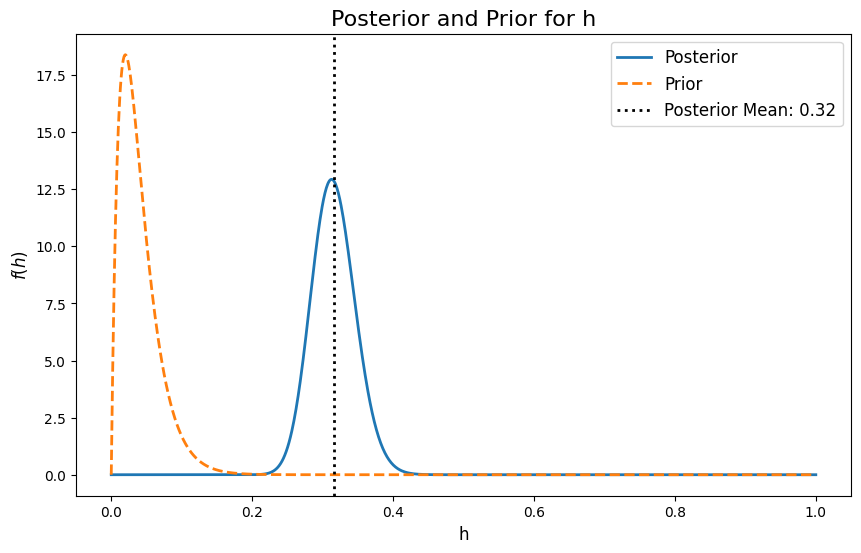

In [29]:
# compute a_n
a_n = a_0 + (y.shape[0] + k) / 2

# compute b_n
resid_beta_n = y - X @ beta_n
b_n = b_0 + (1 / 2) * (resid_beta_n.T @ resid_beta_n + (beta_n - beta_0).T @ np.linalg.inv(V_0) @ (beta_n - beta_0) - 2 * beta_n.T @ V_n @ beta_n)

# plot the posterior
plt.figure(figsize=(10, 6))
plt.plot(x, gamma.pdf(x, a_n, scale = 1/b_n), lw=2, label='Posterior')
plt.plot(x, gamma.pdf(x, a_0, scale = 1/b_0), lw=2, label='Prior', linestyle = '--')
plt.axvline( a_n/ b_n, color='black', linestyle=':', lw=2,
            label=f'Posterior Mean: {a_n / b_n:.2f}')
plt.title(f'Posterior and Prior for h', fontsize=16)
plt.xlabel('h', fontsize=12)
plt.ylabel(r'$f(h)$', fontsize=12)
plt.legend(fontsize=12)
plt.show()




 Now we just need to track down the last part of the posterior $f(\boldsymbol{\beta}|\boldsymbol{y},\boldsymbol{X})$. We have done a lot of tedious algebra. But I promise, we are almost there...

$$f(\boldsymbol{\beta}|\boldsymbol{y},\boldsymbol{X}) = \int \underbrace{f(\boldsymbol{\beta}|\boldsymbol{y}, \boldsymbol{X}, h) f(h|\boldsymbol{y}, \boldsymbol{X})}_{f(\boldsymbol{\beta},h|\boldsymbol{y}, \boldsymbol{X})} dh$$

Inserting the relevant expressions,

$$f(\boldsymbol{\beta}|\boldsymbol{y},\boldsymbol{X}) \propto \int_0^\infty h^{\frac{k}{2}}\exp\bigg(-\frac{h}{2}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)'\boldsymbol{V}_n^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)\bigg) h^{a_n-1} \exp(-b_nh) dh \\ = \int_0^\infty h^{\frac{k}{2}+a_n-1} \exp\bigg(-\bigg[\frac{1}{2}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)'\boldsymbol{V}_n^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)+b_n\bigg]h\bigg)dh  \\ = \int_0^\infty h^{\gamma-1} \exp(-\lambda h)dh$$

- $\gamma = \frac{k}{2}+a_n$
- $\lambda = \frac{1}{2}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)'\boldsymbol{V}_n^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)+b_n $

Wait...this looks oddly familiar. In fact, it is almost the Gamma integral that we met in the binomial example. With a simple change of variable you can show that:

$$\int_0^\infty h^{\gamma-1} \exp(-\lambda h)dh = \frac{\Gamma(\gamma)}{\lambda^\gamma}$$

So,

$$f(\boldsymbol{\beta}|\boldsymbol{y},\boldsymbol{X}) \propto (\frac{1}{2b_n}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)'\boldsymbol{V}_n^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_n)+1)^{-(\frac{k}{2}+a_n)}$$

It turns out that this is the PDF of a $k$-dimensional multivariate t-distribution. The degrees of freedom can be shown to be $\nu = 2 a_n$.The location is clearly $\boldsymbol{\mu} = \boldsymbol{\beta}_n$, and the scale is $\boldsymbol{\Sigma}^{-1} = \frac{a_n}{b_n}\boldsymbol{V}_n^{-1}$. Or, $\boldsymbol{\beta}|\boldsymbol{y}, \boldsymbol{X} \sim t_{2 a_n}(\boldsymbol{\beta}_n, \frac{b_n}{a_n}\boldsymbol{V}_n)$.

Below I shot the final marginal posteriors; which is not the same as the final multivariate posterior. However, collapsing them into individual posteriors allows me to visualise them.

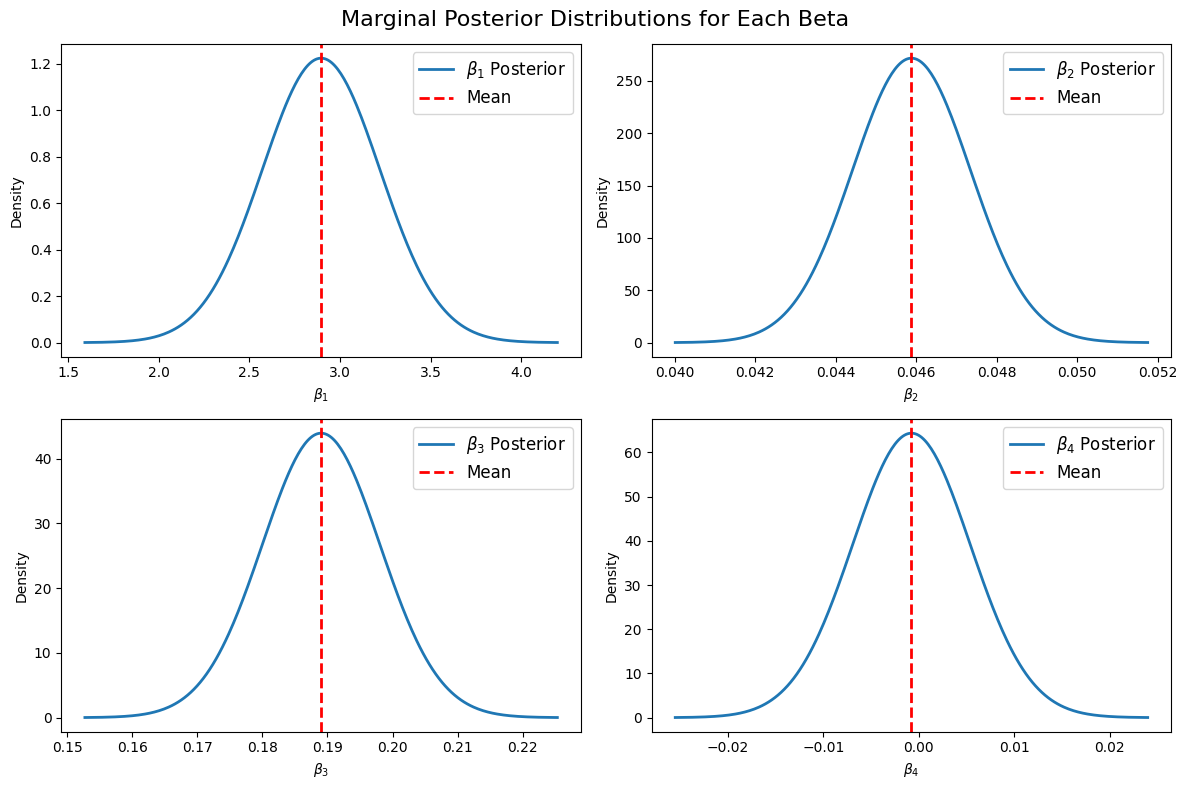

In [37]:
# Create subplots for each beta
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

for i in range(k):
    # Calculate the scale (standard deviation) for the i-th marginal
    scale_i = np.sqrt((b_n / a_n) * V_n[i, i])

    # Create a range of x-values around the posterior mean for beta_i
    x_min = beta_n[i] - 4 * scale_i
    x_max = beta_n[i] + 4 * scale_i
    x_vals = np.linspace(x_min, x_max, 300)

    # Compute the density of the t-distribution for these x-values
    pdf_vals = t.pdf(x_vals, df=2*a_n, loc=beta_n[i], scale=scale_i)

    # Determine the correct subplot index (row, column)
    row = i // 2
    col = i % 2

    # Plot the density and the vertical line at the posterior mean
    axs[row, col].plot(x_vals, pdf_vals, lw=2, label=f'$\\beta_{i+1}$ Posterior')
    axs[row, col].axvline(beta_n[i], color='red', linestyle='--', lw=2, label='Mean')

    # Set labels and legend for the subplot
    axs[row, col].set_xlabel(f'$\\beta_{i+1}$')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend(fontsize=12)

plt.suptitle('Marginal Posterior Distributions for Each Beta', fontsize=16)
plt.tight_layout()
plt.show()



Blimey! That was hard work...But we got there eventually, and by hand! According to our restults, $\beta_3$, which corresponds to radio advertising, has the strongest effects.

Bayes by hand in this way also mirrors OLS in the sense that when $h$ (or the variance) is known, our posterior is normal, whilst our actual posterior is a t-distribution. Now, imagine we had started off with different priors, then we likely wouldn't have been able to work out the posterior by hand by simply spotting distributions and recognising common integrals. This is why next class we will delve into the beating heart of modern Bayes...the computational cornucopia...MONTE CARLO MARKOV CHAINS. I don't understand how they work yet (I promise I will in the next class), but it seems that you can set in motion a sampling algorithm which is a Markov process which, under certain conditions, will converge to the true posterior by using only kernels of distributions. Wow! Get your sunglasses, we are going to Monaco.  